# Overview 

The purpose of this notebook is to explore trends in diabetes prevelance across all American counties, as well as the relationship between the explanatory demographic variables and diabetes prevelance in more populous counties.

# Code Navigation
* [1. Load Packages & Data](#1.LoadPackages&Data)
* [2. Preprocessing](#2.Preprocessing)
* [3. Exploring Diabetes Trends all Counties](#3.ExploringDiabetesTrendsallCounties)
* [4. Exploring Explanatory Variables Populous Counties](#4.ExploringExplanatoryVariablesPopulousCounties)
* [5. Saving Data](#5.SavingData)

## 1. Load Packages & Data <a class="anchor" id="1.LoadPackages&Data"></a>

In [1]:
import requests
import pandas as pd
import csv
import os
import sys
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from tqdm import tqdm

#Set Seaborn Styles
sns.set_style("white")
sns.set(font_scale=1.75)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Change directory to project root directory
os.chdir("..")

#Import custom code
from src.code_flow.CreateJupyterNotebookHeadings import jupyternotebookheadings1, jupyternotebookheadings2

In [2]:
#Load the data
df_demo=pd.read_csv('data/interim/diabetes_ACS_populous_counties_2004to2019.csv',index_col=0)
df_pop_all=pd.read_csv('data/interim/population_diabetes_allcounties_2004_2017.csv',index_col=0)
df_geog=gpd.read_file('data/external/US_Counties_Atlas/USA_Counties.shp')

## 2. Preprocessing <a class="anchor" id="2.Preprocessing"></a>

#### Add region labels - both data sets.

In [3]:
#Function to return Map region labels 
def region_label(x):
    if x in Northeast:
        return "Northeast"
    if x in West:
        return "West"
    if x in Midwest:
        return "Midwest"
    if x in South:
        return "South"
    
#Define regions; (mostly) based on US Census Bureau's definition; Maryland, DC and Delaware were moved to Northeast region.
Northeast=['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'Pennsylvania', 'New Jersey','Delaware', 'Maryland', 'District of Columbia']
Midwest=['Wisconsin', 'Michigan', 'Illinois', 'Indiana', 'Ohio', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Minnesota', 'Iowa', 'Missouri']
South=['Puerto Rico', 'Virginia', 'West Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida', 'Kentucky', 'Tennessee', 'Mississippi', 'Alabama', 'Oklahoma', 'Texas', 'Arkansas', 'Louisiana']
West=['Idaho', 'Montana', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 'Arizona', 'New Mexico', 'Alaska', 'Washington', 'Oregon', 'California', 'Hawaii']

#Add region columns to both data frames
df_pop_all['region']=df_pop_all.state.apply(region_label)
df_demo['region']=df_demo.state.apply(region_label)

#### Prepare & merge geographic dataframe with all county population & diabetes data for later mapping.

In [4]:
#Alter the variable types of the columns that will be used for the merge
df_geog.STATE_FIPS=df_geog.STATE_FIPS.astype('int')
df_geog.CNTY_FIPS=df_geog.CNTY_FIPS.astype('int')

#Drop unnecessary columns from geography data frame
df_geog=df_geog[['FID', 'OBJECTID', 'NAME', 'STATE_NAME', 'STATE_FIPS', 'CNTY_FIPS',
       'FIPS', 'SQMI', 'Shape_Leng', 'SHAPE_Le_1', 'SHAPE_Area', 'geometry']]

#Merge all diabetes/population data with geography data frame
df_pop_geog=df_geog.merge(df_pop_all, right_on=['state_fips','county_fips'],left_on=['STATE_FIPS','CNTY_FIPS'],how='inner').drop(columns=['STATE_FIPS','CNTY_FIPS'])

#### Distinguish counties as being greatly or lightly populated in the all county dataset, with a cut off of 100,000

In [5]:
conditions = [
    (df_pop_all.total_population < 100000),
    (df_pop_all.total_population < 250000) & (df_pop_all.total_population >100000),
    (df_pop_all.total_population > 250000)]
choices = ["Pop<100K","100K<Pop<250K","250K<Pop"]
df_pop_all['population_size'] = np.select(conditions, choices)

In [6]:
#df_pop_all['population_size']=np.where(df_pop_all.total_population>100000,
#                                       'Larger Population (>100K)','Smaller Population (<100K)')

#### Slight changes to census demographic dataset. 

In [7]:
#Census Demographic Data
#Add a column that adds the 55-59 and 60-64 columns together for consistency
df_demo['55_64_years']=df_demo['60_64_years']+df_demo['55_59_years']

#Drop the 55-59 and 60-64 columns
df_demo.drop(columns=['60_64_years','55_59_years'],inplace=True)

#Reorder variables
df_demo=df_demo[['state', 'county','region', 'county_fips', 'state_fips', 'year',
        'total_pop','female','male',
        'white_pop','black_pop', 'amer_indian_pop', 
        'pacific_island_pop', 'asian_pop','hispanic_pop','other_pop', '20_24_years',
        '25_34_years','35_44_years', '45_54_years', '55_64_years',
        '65_74_years', '75_84_years', '85_plus_years', 'median_income','education_bach', 'education_hs',
        'diabetes_%', 'diabetes_%_lower','diabetes_%_upper']]

## 3. Exploring Diabetes Trends all Counties <a class="anchor" id="3.ExploringDiabetesTrendsallCounties"></a>

#### What are the trends in diabetes prevance across time & regions?

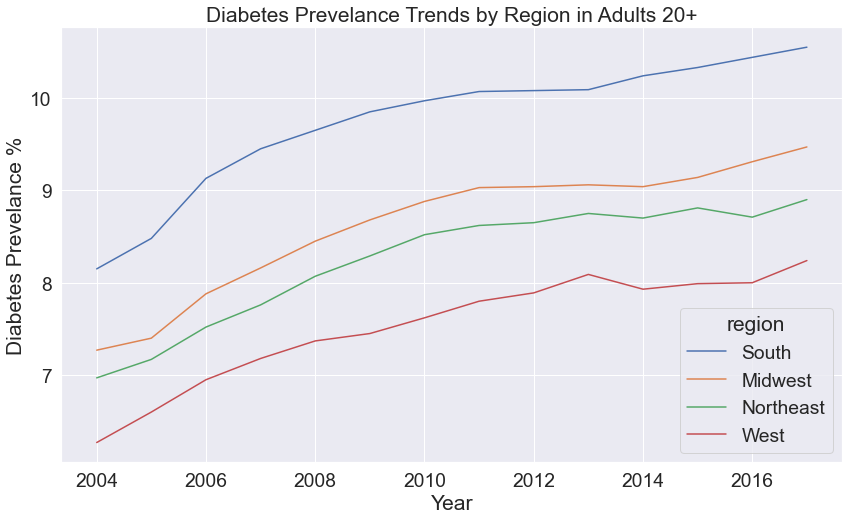

In [8]:
#Calculate diabetes prevelance by region overtime 
agg_func={'adult_diabetes_pop':'sum','adult_pop':'sum'}
df_diab_region=df_pop_all.groupby(['region','year']).agg(agg_func)
df_diab_region['region_%']=round((df_diab_region.adult_diabetes_pop/df_diab_region.adult_pop)*100,2)
df_diab_region.reset_index(inplace=True)

#Plot diabetes prevelance trends by region
order=['South','Midwest','Northeast','West']
plt.rcParams.update({'font.size': 15})
plt.subplots(figsize=(14,8))
sns.lineplot(y='region_%',x='year',hue='region',data=df_diab_region,hue_order=order)
plt.title('Diabetes Prevelance Trends by Region in Adults 20+')
plt.xlabel('Year')
plt.ylabel('Diabetes Prevelance %')
plt.show()

There is a significant trend upwards in all regions from 2004 to 2017 - in all regions, the prevelance of diabetes increases by at least 2% of its adult population. In all years, the South has the highest prevelance while the West has the least.

**What do the trends look like in 4 random counties from different regions?**

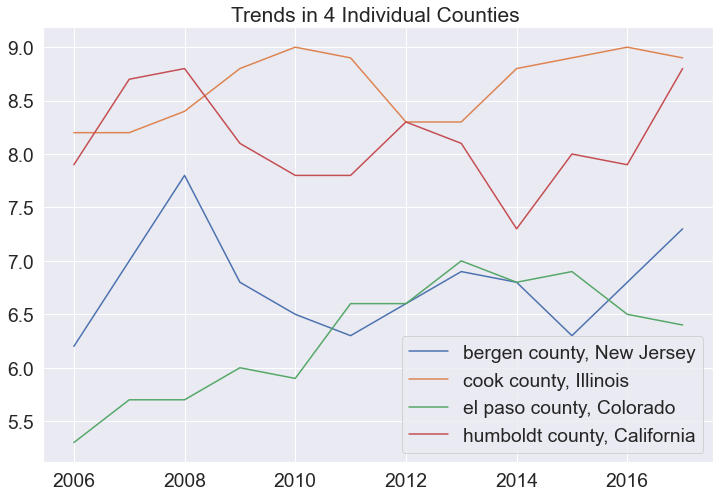

In [9]:
#Combine state & county fips
df_demo.state_fips=df_demo.state_fips.astype('int')
df_demo.county_fips=df_demo.county_fips.astype('int')
df_demo['state_county_fips']=df_demo.state_fips.astype('str')+' '+df_demo.county_fips.astype('str')

fips=['34 3','17 31','8 41','6 23']
plt.subplots(figsize=(12,8))
for i in fips:
    state_=df_demo[df_demo.state_county_fips==i][['state','county']].iloc[0,0]
    county_=df_demo[df_demo.state_county_fips==i][['state','county']].iloc[0,1]
    df_plot=df_demo[df_demo.state_county_fips==i]
    plt.plot(df_plot.year,df_plot['diabetes_%'],label=county_+', '+state_)
    #plt.xticks([0,2,4,6,8,10],[2006,2008,2010,2012,2014,2016])
    plt.title('Trends in 4 Individual Counties ')
    plt.legend()

#### What does the diabetes prevelance look like for individual counties in 2004 vs 2017?

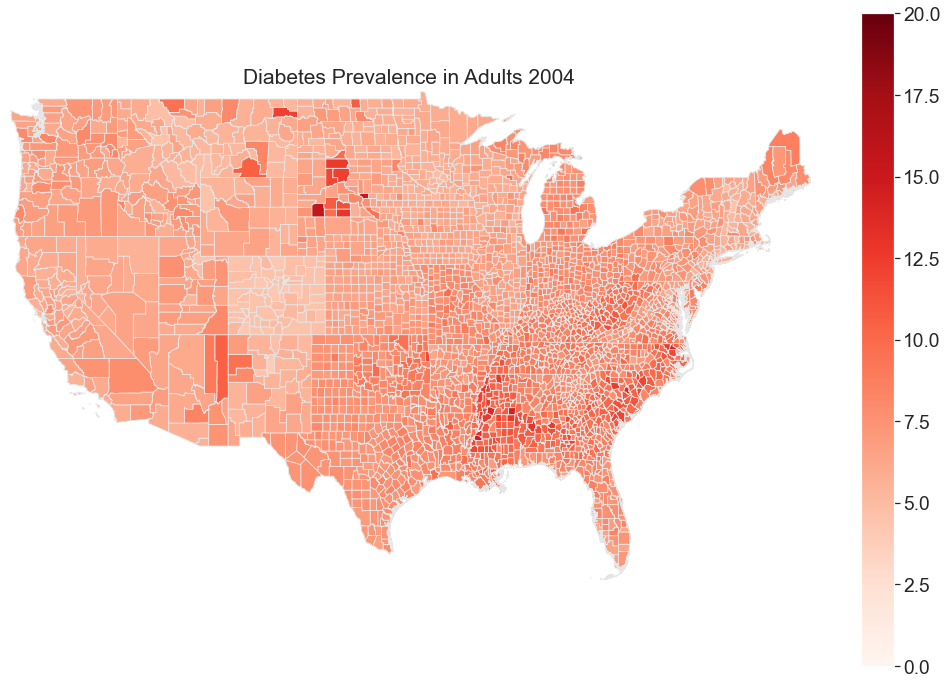

In [10]:
#Plot US county prevelance in 2004.
fig, ax = plt.subplots(1, figsize=(18, 12))
ax.set_ylim([24,49.5])
ax.set_xlim([-125,-67])
df_pop_geog[df_pop_geog.year==2004].plot(column='diabetes_%', 
                                         cmap="Reds", linewidth=0.8, ax=ax, edgecolor='0.9',legend=True,
                                         vmin=0, vmax=20,
                                         missing_kwds={"color":"lightgrey"})
plt.title('Diabetes Prevalence in Adults 2004')
plt.axis('off')
plt.show()

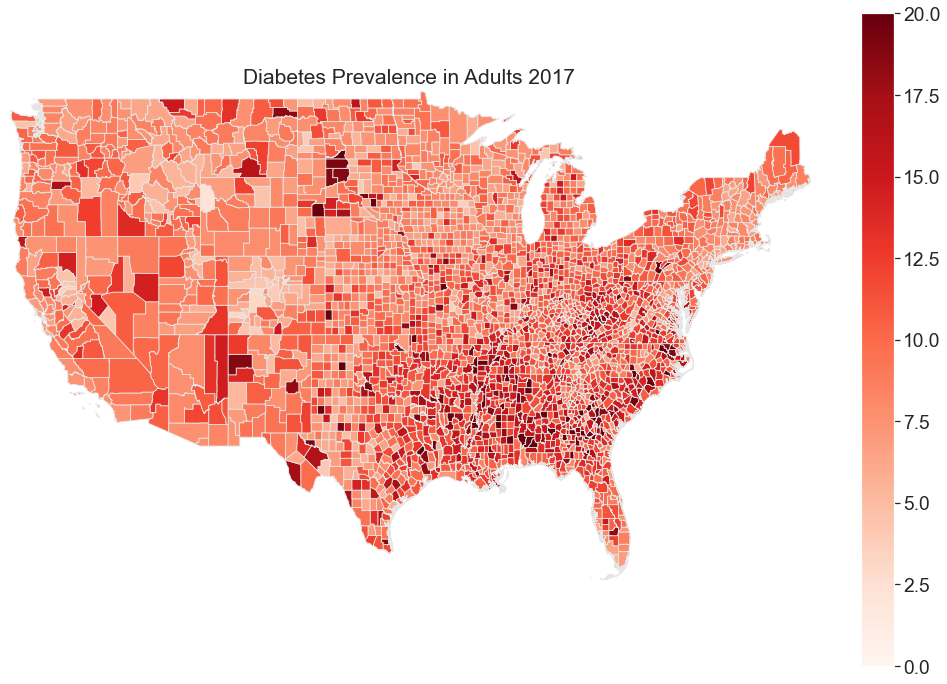

In [11]:
#Plot US county prevelance in 2017 with the same color scale
fig, ax = plt.subplots(1, figsize=(18, 12))
ax.set_ylim([24,49.5])
ax.set_xlim([-125,-67])
df_pop_geog[df_pop_geog.year==2017].plot(column='diabetes_%', 
                                         cmap="Reds", linewidth=0.8, ax=ax, edgecolor='0.9',legend=True,
                                         vmin=0, vmax=20,
                                         missing_kwds={"color":"lightgrey"})
plt.title('Diabetes Prevalence in Adults 2017')
plt.axis('off')
plt.show()

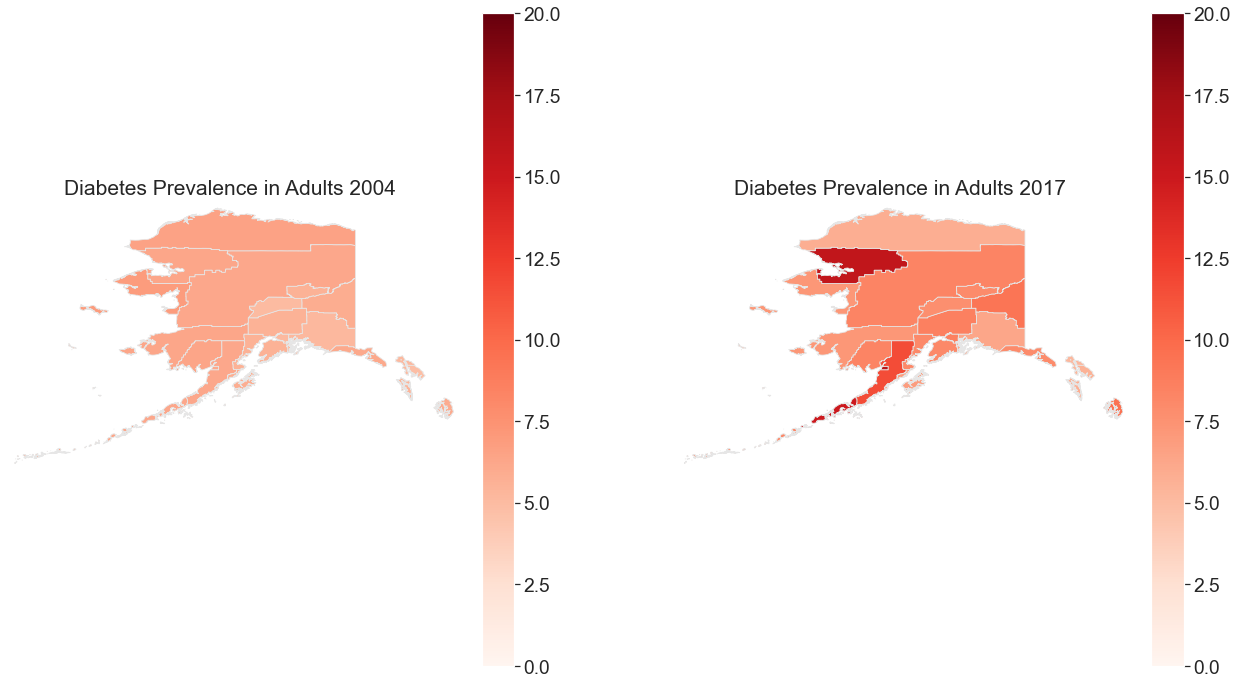

In [12]:
#Plot Alaska county prevelance in 2017 & 2004
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 12))
ax1.set_ylim([50,72])
ax1.set_xlim([-180,-130])
ax2.set_ylim([50,72])
ax2.set_xlim([-180,-130])
ax1=df_pop_geog[df_pop_geog.year==2004].plot(column='diabetes_%', 
                                         cmap="Reds", linewidth=0.8, ax=ax1, edgecolor='0.9',legend=True,
                                         vmin=0, vmax=20,
                                         missing_kwds={"color":"lightgrey","label": "Missing data"})
ax2=df_pop_geog[df_pop_geog.year==2017].plot(column='diabetes_%', 
                                         cmap="Reds", linewidth=0.8, ax=ax2, edgecolor='0.9',legend=True,
                                         vmin=0, vmax=20,
                                         missing_kwds={"color":"lightgrey"})
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Diabetes Prevalence in Adults 2004')
ax2.set_title('Diabetes Prevalence in Adults 2017')
plt.show()

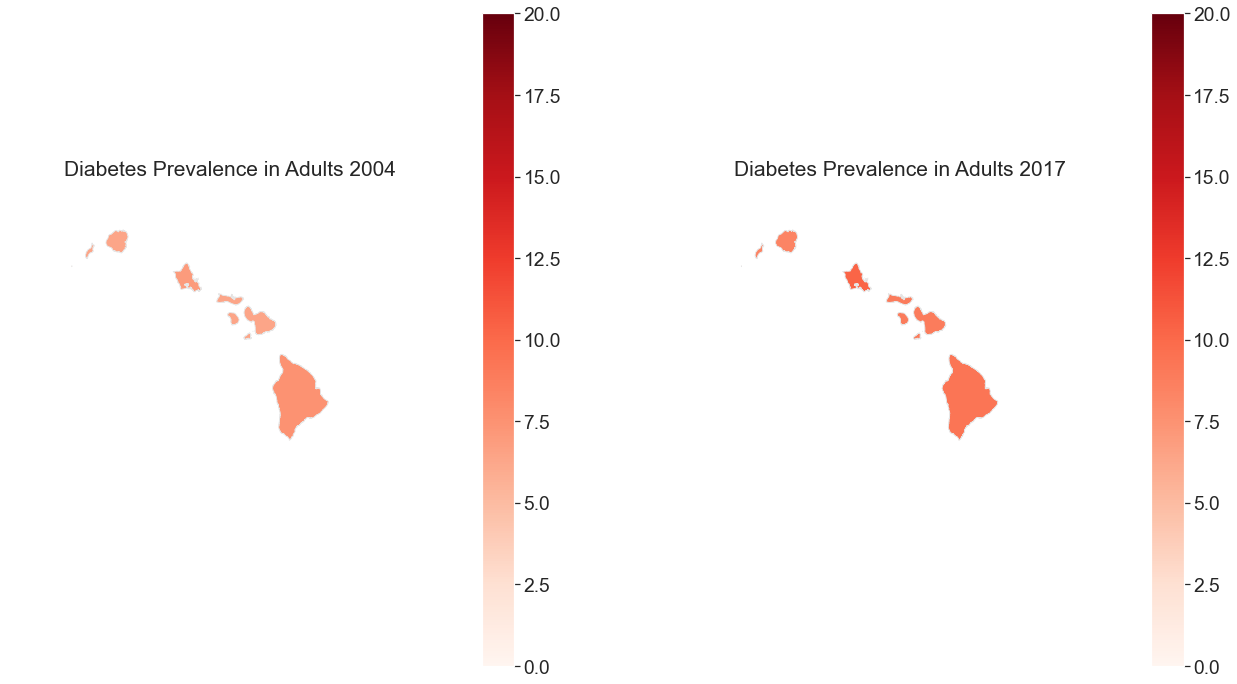

In [13]:
#Plot Hawaii county prevelance in 2017 & 2004
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22, 12))
ax1.set_ylim([18,23])
ax1.set_xlim([-162,-152])
ax2.set_ylim([18,23])
ax2.set_xlim([-162,-152])
ax1=df_pop_geog[df_pop_geog.year==2004].plot(column='diabetes_%', 
                                         cmap="Reds", linewidth=0.8, ax=ax1, edgecolor='0.9',legend=True,
                                         vmin=0, vmax=20,
                                         missing_kwds={"color":"lightgrey","label": "Missing data"})
ax2=df_pop_geog[df_pop_geog.year==2017].plot(column='diabetes_%', 
                                         cmap="Reds", linewidth=0.8, ax=ax2, edgecolor='0.9',legend=True,
                                         vmin=0, vmax=20,
                                         missing_kwds={"color":"lightgrey"})
ax1.set_title('Diabetes Prevalence in Adults 2004')
ax2.set_title('Diabetes Prevalence in Adults 2017')
ax1.axis('off')
ax2.axis('off')
plt.show()

####  With these maps, we see that in some counties, particularly in the south the prevelance of diabetes has more than doubled from 2004 to 2017. Most likely, these counties are less populated. Let's explore this further.

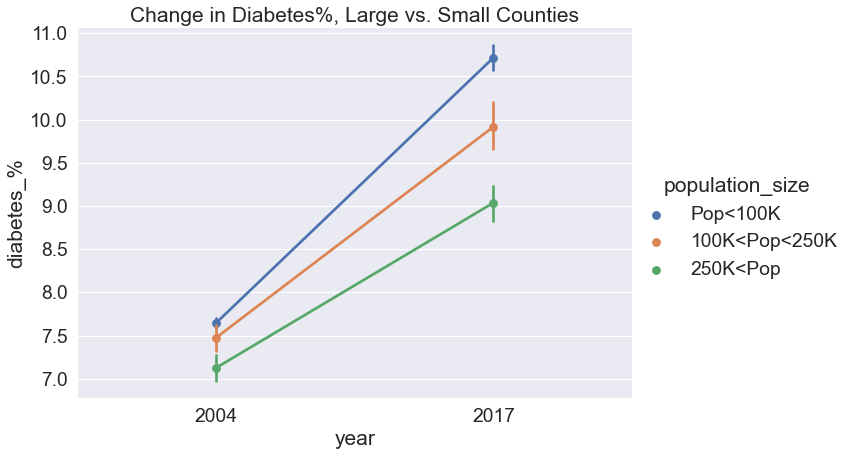

In [14]:
#Plot the average difference between 2004 and 2017 in all counties, 
#distinguishing counties with a population less than 100K
sns.catplot(x='year',y='diabetes_%',data=df_pop_all[(df_pop_all.year==2004)|(df_pop_all.year==2017)],
           kind='point',hue='population_size',estimator=np.mean,height=6,aspect=1.5,hue_order=choices)
plt.title('Change in Diabetes%, Large vs. Small Counties')
plt.show()

#### There is a greater increase in diabetes in less populous than more populous counties, which suggests an urban/rural divide.

## 4. Exploring Explanatory Variables Populous Counties <a class="anchor" id="4.ExploringExplanatoryVariablesPopulousCounties"></a>

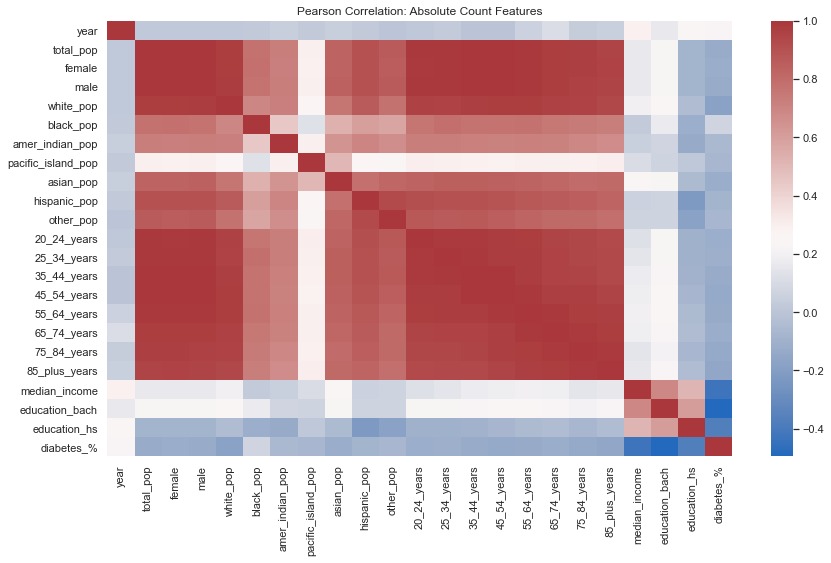

In [15]:
#Set Font scale for this graph
sns.set(font_scale=1)

#Plot the correlation of the (mostly) absolute count features
plt.subplots(figsize=(14,8))
sns.color_palette("vlag", as_cmap=True)
sns.heatmap(df_demo.drop(columns=['county_fips','state_fips','diabetes_%_upper','diabetes_%_lower']).corr(),cmap='vlag')
plt.title('Pearson Correlation: Absolute Count Features')
plt.show()

#### Many of these variables are either highly positive or highly negatively correlated. This is because absolute counts of demographic information is used rather than relative percentages - so we're mostly just seeing the difference between small and large counties. Below I'll calculate relative percentages instead.

In [16]:
#Copy the dataframe
df_demo_relative=df_demo.copy()

#Account for time as years since 2006 rather than 2006-2019
df_demo_relative['years_since_2006']=df_demo_relative.year-2006
df_demo_relative.drop(columns='year',inplace=True)
             
#List variables to convert to percentage
abs_var=['female','male','white_pop','black_pop', 'amer_indian_pop', 
        'pacific_island_pop', 'asian_pop','hispanic_pop','other_pop', '20_24_years',
        '25_34_years','35_44_years', '45_54_years', '55_64_years',
        '65_74_years', '75_84_years', '85_plus_years']

#Convert absolute # to %
for var in abs_var:
    df_demo_relative[var]=round((df_demo_relative[var]/df_demo_relative['total_pop'])*100,2)

#Print a slice of the dataframe 
df_demo_relative.head(10)

,state,county,region,county_fips,state_fips,total_pop,female,male,white_pop,black_pop,amer_indian_pop,pacific_island_pop,asian_pop,hispanic_pop,other_pop,20_24_years,25_34_years,35_44_years,45_54_years,55_64_years,65_74_years,75_84_years,85_plus_years,median_income,education_bach,education_hs,diabetes_%,diabetes_%_lower,diabetes_%_upper,state_county_fips,years_since_2006
12,Alabama,baldwin county,South,3,1,169162.0,50.75,49.25,87.63,10.15,1.16,0.0,0.56,2.47,1.97,6.65,13.20,13.94,14.19,11.71,8.35,6.28,1.32,44878.0,25.8,86.7,7.8,6.2,9.6,1 3,0.0
13,Alabama,baldwin county,South,3,1,171769.0,51.00,49.00,87.43,10.48,0.92,0.0,0.35,2.69,1.46,5.56,13.37,13.40,14.03,11.31,8.51,6.09,1.81,49119.0,26.4,88.3,8.1,6.7,9.7,1 3,1.0
14,Alabama,baldwin county,South,3,1,174439.0,50.72,49.28,87.42,10.08,1.78,0.0,0.90,2.88,1.51,4.95,14.46,13.43,13.49,11.35,8.61,6.29,1.62,52320.0,29.5,87.9,8.6,7.1,10.0,1 3,2.0
15,Alabama,baldwin county,South,3,1,179878.0,51.15,48.85,86.89,10.19,0.97,0.0,0.82,3.31,1.98,5.37,12.61,12.88,14.33,12.52,9.66,5.37,2.04,48487.0,26.5,89.2,9.9,8.5,11.5,1 3,3.0
16,Alabama,baldwin county,South,3,1,183195.0,50.91,49.09,88.50,9.86,1.29,0.0,0.95,4.41,0.99,4.60,11.77,12.89,14.89,13.57,9.99,5.01,1.73,47502.0,27.2,87.7,10.2,8.7,11.9,1 3,4.0
17,Alabama,baldwin county,South,3,1,186717.0,51.74,48.26,88.03,10.08,1.27,0.0,0.96,4.53,0.92,4.86,12.53,12.66,14.38,13.76,9.84,5.13,1.98,50900.0,28.3,90.4,9.8,8.3,11.4,1 3,5.0
18,Alabama,baldwin county,South,3,1,190790.0,50.95,49.05,88.70,10.19,1.29,0.0,1.21,4.58,1.22,5.77,11.87,11.82,14.87,13.65,10.65,5.32,1.77,48378.0,29.1,89.2,9.1,7.6,10.6,1 3,6.0
19,Alabama,baldwin county,South,3,1,195540.0,51.47,48.53,87.64,10.91,0.31,0.0,1.12,4.58,1.17,6.31,11.80,12.33,12.99,13.98,10.74,5.05,2.17,44874.0,29.0,90.6,8.8,7.3,10.2,1 3,7.0
20,Alabama,baldwin county,South,3,1,200111.0,50.89,49.11,87.61,10.03,1.48,0.0,1.19,4.56,1.61,4.90,11.73,12.32,13.47,13.86,11.19,5.79,1.90,48461.0,30.5,89.0,9.3,8.0,10.8,1 3,8.0
21,Alabama,baldwin county,South,3,1,203709.0,50.80,49.20,86.83,11.45,1.39,0.0,0.29,4.55,1.10,5.07,11.65,12.48,13.41,13.39,12.15,5.17,2.30,52003.0,29.5,90.8,9.3,8.0,10.7,1 3,9.0


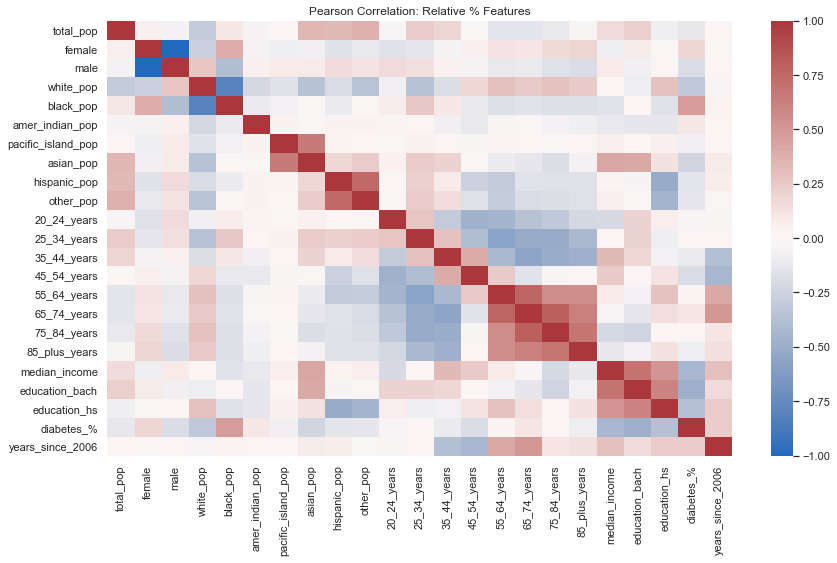

In [17]:
#Plot the correlation of the relative % features
plt.subplots(figsize=(14,8))
plt.rcParams.update({'font.size': 12})
sns.heatmap(df_demo_relative.drop(columns=['county_fips','state_fips','diabetes_%_upper','diabetes_%_lower']).corr(),cmap='vlag')
plt.title('Pearson Correlation: Relative % Features')
plt.show()

**Pearson's correlation is more suceptible to outliers, so let's calculate the correlation using Spearman's instead.**

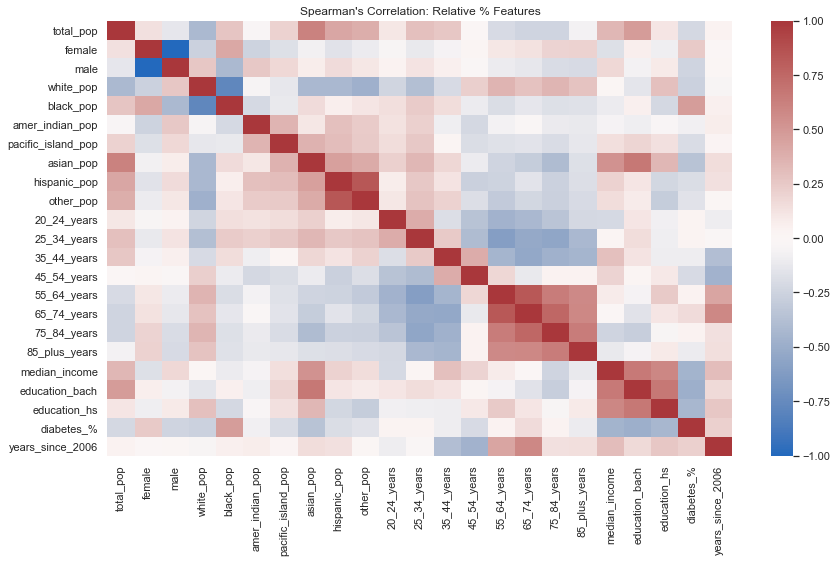

In [18]:
#Plot the correlation of the relative % features
plt.subplots(figsize=(14,8))
plt.rcParams.update({'font.size': 12})
sns.heatmap(df_demo_relative.drop(columns=['county_fips','state_fips','diabetes_%_upper','diabetes_%_lower']).corr(method='spearman'),cmap='vlag')
plt.title("Spearman's Correlation: Relative % Features")
plt.show()

#### This correlation map checks out. For example we generally see a negative correlation between races, as the share of one race goes up, another will go down. With age brackets, the counties seem to skew either older or younger - as the share of a younger age bracket goes up, so to do the younger ages near it tend to; as the share of younger brackets go down, the share of older brackets go up. 

#### Median income is highly positively correlated with education, which is not a surprise.

#### Unfortunately we can also clearly see a difference in life expectancy between races. As the share of the black population in a county goes up, the share of elderly goes down; the opposite is true of the white population. 

#### The correlations with diabetes%, the target variable, are quite colorful. Given the more healthy range of correlations in this relative % data as well as its more direct correspondence with the diabetes % data, I will use it to create the model rather than the absolute count data.

In [19]:
#Calculate % of counties & total US population captured in the ACS demographic data
pop_2006=round(df_demo[df_demo.year==2006].total_pop.sum()/1000000,1)
pop_2019=round(df_demo[df_demo.year==2019].total_pop.sum()/1000000,1)
us_pop_2006=298.4
us_pop_2019=328.2
pct_2006=round((pop_2006/us_pop_2006)*100,1)
pct_2019=round((pop_2019/us_pop_2019)*100,1)
num_counties_2006=len(df_demo[df_demo.year==2016][['state','county']].value_counts().index.values)
num_counties_2019=len(df_demo[df_demo.year==2019][['state','county']].value_counts().index.values)

print("In 2006, about {} US counties had a population greater than 65K, and had a total population of {} million.\n\
This accounts for {}% of the US population that year.".format(num_counties_2006,pop_2006,pct_2006))
print(" ")
print("In 2019, about {} US counties had a population greater than 65K, and had a total population of {} million.\n\
This accounts for {}% of the US population that year.".format(num_counties_2019,pop_2019,pct_2019))

In 2006, about 807 US counties had a population greater than 65K, and had a total population of 250.2 million.
This accounts for 83.8% of the US population that year.
 
In 2019, about 806 US counties had a population greater than 65K, and had a total population of 277.9 million.
This accounts for 84.7% of the US population that year.


#### Next I'll plot the relationship between diabetes prevalence and each explanatory vairable.

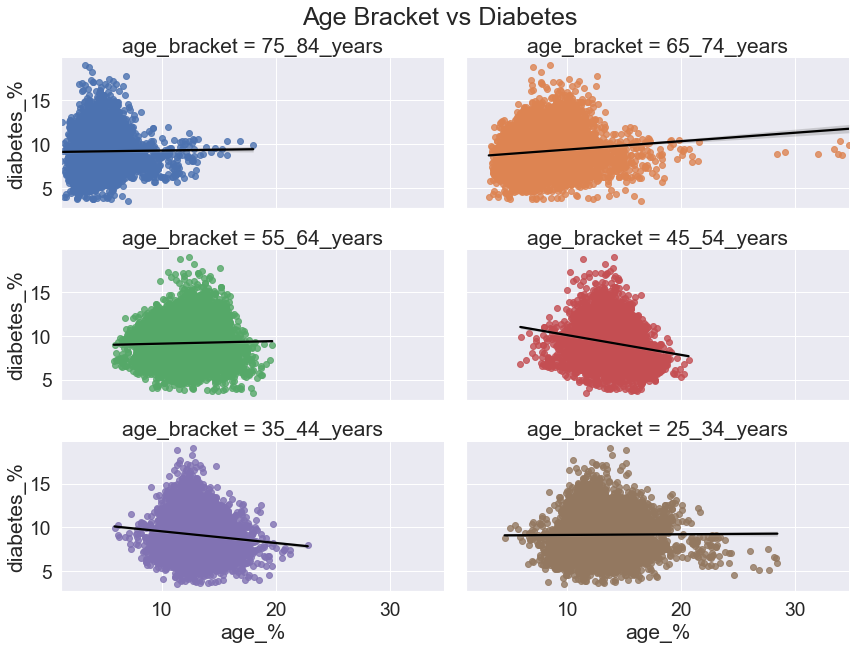

In [20]:
#Set Font Scale Back
sns.set(font_scale=1.75)

#Plot Age Bracket % vs Diabetes
value_vars=['75_84_years','65_74_years','55_64_years','45_54_years','35_44_years','25_34_years']
age_df=pd.melt(df_demo_relative,value_vars=value_vars,id_vars='diabetes_%',var_name='age_bracket',value_name='age_%')
lm=sns.lmplot(y='diabetes_%',x='age_%',hue='age_bracket',col='age_bracket',
           col_wrap=2,data=age_df,height=3,aspect=2,line_kws={'color': 'black'},legend=True)
fig = lm.fig 
fig.suptitle("Age Bracket vs Diabetes")
lm.fig.subplots_adjust(top=.9)
plt.show()

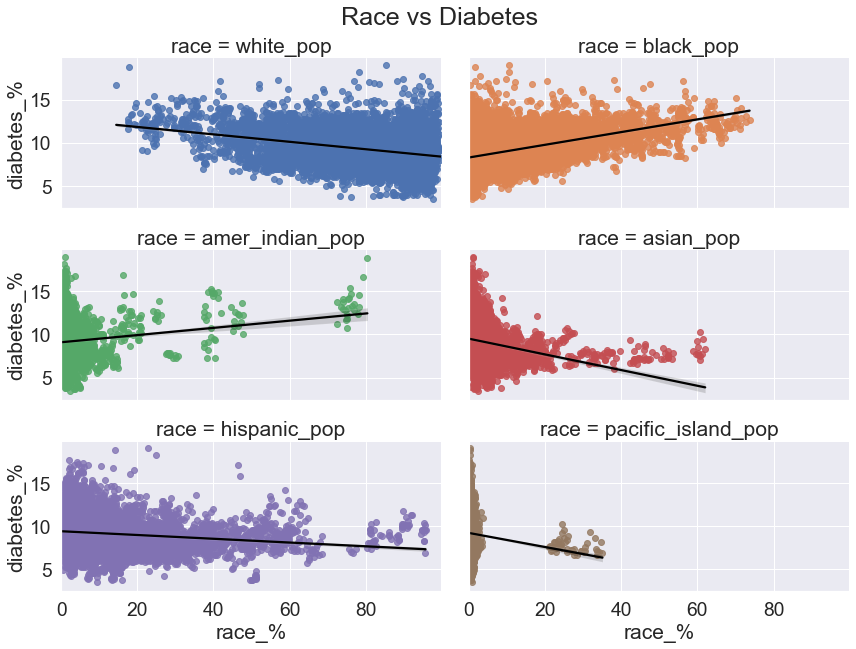

In [21]:
#Plot Race vs Diabetes
value_vars=['white_pop','black_pop','amer_indian_pop','asian_pop','hispanic_pop','pacific_island_pop']
demo_df=pd.melt(df_demo_relative,value_vars=value_vars,id_vars='diabetes_%',var_name='race',value_name='race_%')
lm=sns.lmplot(y='diabetes_%',x='race_%',hue='race',col='race',
           col_wrap=2,data=demo_df,height=3,aspect=2,line_kws={'color': 'black'},legend=True)
fig = lm.fig 
fig.suptitle("Race vs Diabetes")
lm.fig.subplots_adjust(top=.9)
plt.show()

In [22]:
#What counties have the highest percentage of Native Americans?
pd.DataFrame(df_demo_relative[df_demo_relative.amer_indian_pop>20].groupby(['county','state'])
             .amer_indian_pop.mean().sort_values(ascending=False))

,,amer_indian_pop
county,state,
mckinley county,New Mexico,77.302857
apache county,Arizona,74.717143
navajo county,Arizona,46.481429
robeson county,North Carolina,39.597143
san juan county,New Mexico,39.571429
coconino county,Arizona,28.722857
muskogee county,Oklahoma,24.069286
rogers county,Oklahoma,20.497000


In [23]:
#What counties have the highest percentage of Pacific Island Population?
pd.DataFrame(df_demo_relative[df_demo_relative.pacific_island_pop>10].groupby(['county','state'])
             .pacific_island_pop.mean().sort_values(ascending=False))

,,pacific_island_pop
county,state,
hawaii county,Hawaii,32.132143
maui county,Hawaii,27.438571
kauai county,Hawaii,23.607143
honolulu county,Hawaii,23.500714


In [24]:
#What counties have the highest percentage of Asian Population?
pd.DataFrame(df_demo_relative[df_demo_relative.asian_pop>25].groupby(['county','state'])
             .asian_pop.mean().sort_values(ascending=False))

,,asian_pop
county,state,
honolulu county,Hawaii,60.581429
kauai county,Hawaii,51.890000
maui county,Hawaii,46.732857
hawaii county,Hawaii,43.509286
santa clara county,California,36.136429
san francisco county,California,35.952143
alameda county,California,30.403571
san mateo county,California,29.307143
queens county,New York,26.710000


In [25]:
#What counties have the highest percentage of hispanic Population?
pd.DataFrame(df_demo_relative[df_demo_relative.hispanic_pop>60].groupby(['county','state'])
             .hispanic_pop.mean().sort_values(ascending=False))

,,hispanic_pop
county,state,
webb county,Texas,95.242143
hidalgo county,Texas,90.925000
cameron county,Texas,88.183571
el paso county,Texas,81.856429
imperial county,California,80.892857
doña ana county,New Mexico,66.581429
miami-dade county,Florida,65.397143
tulare county,California,63.228000
nueces county,Texas,62.400909


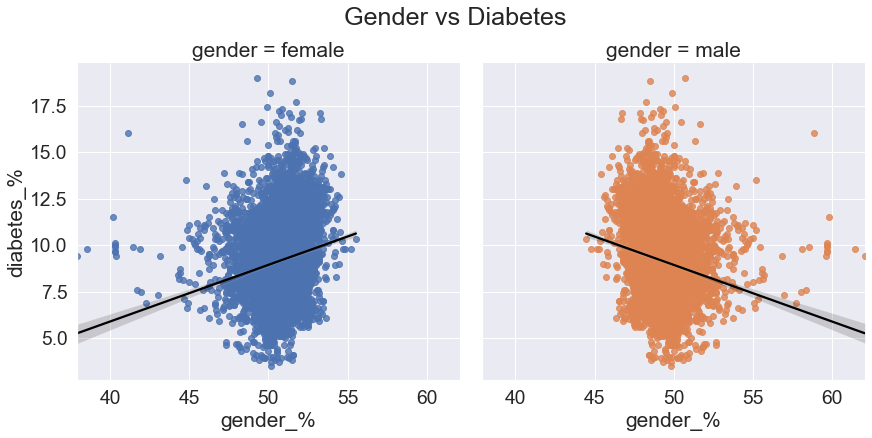

In [26]:
#Plot Gender vs Diabetes
sns.set(font_scale=1.75)
value_vars=['female','male']
gender_df=pd.melt(df_demo_relative,value_vars=value_vars,id_vars='diabetes_%',var_name='gender',value_name='gender_%')
lm=sns.lmplot(y='diabetes_%',x='gender_%',hue='gender',col='gender',
           col_wrap=2,data=gender_df,height=6,aspect=1,line_kws={'color': 'black'},legend=True)
fig = lm.fig 
fig.suptitle("Gender vs Diabetes")
lm.fig.subplots_adjust(top=.85)
plt.show()

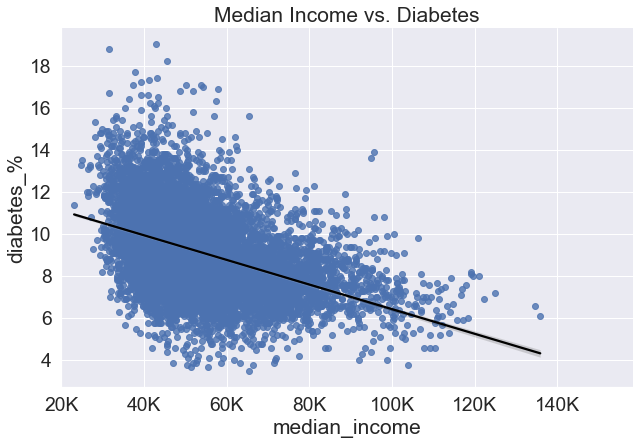

In [27]:
#Plot Median Income vs Diabetes
_=sns.lmplot(x='median_income',y='diabetes_%',data=df_demo_relative,height=6,aspect=1.5,line_kws={'color': 'black'})
_.set(xticks=[i*20000 for i in range(1,8)])
_.set(xticklabels=['20K','40K','60K','80K','100K','120K','140K'])
plt.title('Median Income vs. Diabetes')
plt.show()

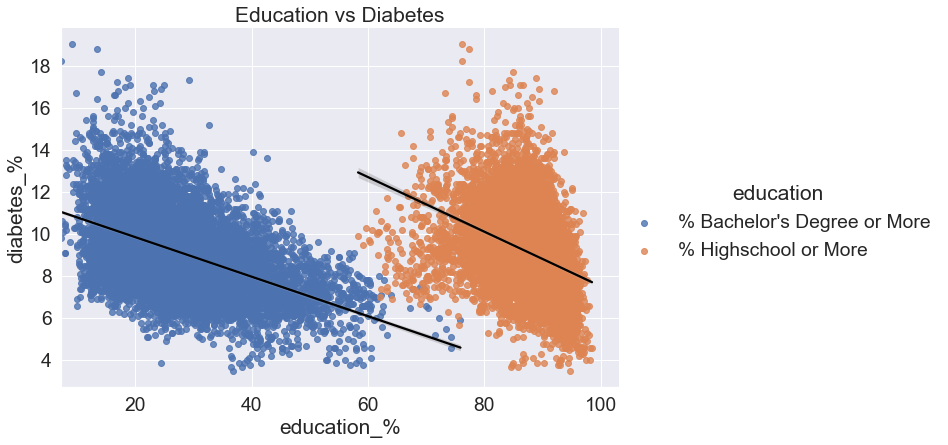

In [28]:
#Plot Education vs Diabetes
value_vars=['education_bach','education_hs']
edu_df=pd.melt(df_demo_relative,value_vars=value_vars,id_vars='diabetes_%',var_name='education',value_name='education_%')
edu_df['education']=edu_df.education.map({'education_bach':"% Bachelor's Degree or More",'education_hs':"% Highschool or More"})
sns.lmplot(y='diabetes_%',x='education_%',hue='education',
           data=edu_df,height=6,aspect=1.5,line_kws={'color': 'black'},legend=True)
plt.title("Education vs Diabetes")
plt.show()

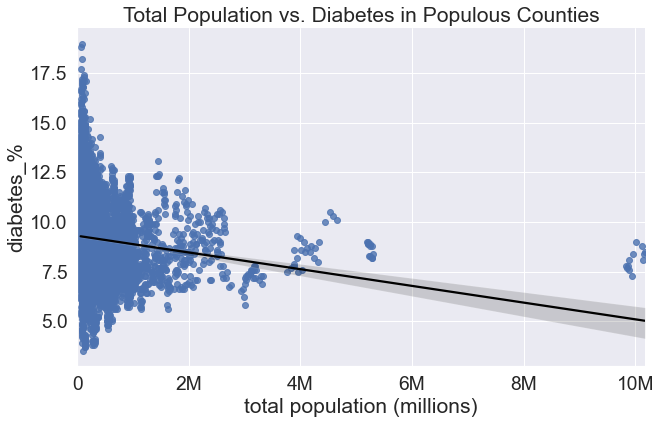

In [29]:
#Plot Total Population vs Diabetes
_=sns.lmplot(x='total_pop',y='diabetes_%',data=df_demo_relative,line_kws={'color': 'black'},height=6,aspect=1.5)
_.set(xticks=[(i*2)*10**6 for i in range(0,6)])
_.set(xticklabels=['0','2M','4M','6M','8M','10M'])
_.set(xlabel='total population (millions)')
plt.title('Total Population vs. Diabetes in Populous Counties')
plt.show()

In [30]:
#What are the most populous counties?
pd.DataFrame(df_demo[df_demo.total_pop>2000000].groupby(['county','state'])
             .total_pop.agg(lambda x: round(np.mean(x)/1000000,3))).sort_values(by='total_pop',ascending=False)

,,total_pop
county,state,
los angeles county,California,9.998
cook county,Illinois,5.234
harris county,Texas,4.314
maricopa county,Arizona,4.070
san diego county,California,3.179
orange county,California,3.097
miami-dade county,Florida,2.590
kings county,New York,2.574
dallas county,Texas,2.489


## 5. Saving Data <a class="anchor" id="5.SavingData"></a>

In [31]:
#Write all county population & diabetes data to a shape file for Tableau 
#df_pop_geog.to_file('data/processed/post_eda_population_diabetes_allcounties_2004_2017.shp')

#Write demographic & diabetes data for populous counties to a csv file
df_demo_relative.to_csv('data/interim/post_eda_diabetes_ACS_populous_counties_2004to2019.csv')